In [1]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "04_detect_segment/04b_unet_segmentation.ipynb" # change to reflect your notebook
_nb_title = "Modified U-Net on Pets dataset" # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Modified+U-Net+on+Pets+dataset&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F04_detect_segment%2F04b_unet_segmentation.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/04_detect_segment/04b_unet_segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# U-Netによるセマンティックセグメンテーション
このノートブックでは、U-Netを利用してOxford-IIIT Petsデータセットに対してセマンティックセグメンテーションを行います。エンコーダ部分には学習済みのMobileNetを使用し、デコーダにはKerasのアップサンプリング層を利用します。

[TensorFlowの公式チュートリアル](https://www.tensorflow.org/tutorials/images/segmentation)をベースに作成されています。

## 実行環境
このノートブックは、TPUまたはGPUで実行するように設定されています。<br>
**GPUでは実行に時間がかかるため、特にTPUでの実行を推奨しています。**

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

また、TPUでのトレーニングのために、書き込み可能なGCSバケットを使用する必要があります。以下のGCSバケットのセクションの手順に従ってセットアップを行ってください。

In [2]:
import os, re
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

import tensorflow_datasets as tfds
print(tfds.__version__)


2022-12-10 20:43:56.443331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 20:43:56.443376: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [29]:
# If you are running on Colaboratory, you must authenticate
# for Colab to have write access to the bucket.

IS_COLAB_BACKEND = 'COLAB_RELEASE_TAG' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
    from google.colab import auth
    auth.authenticate_user()

## Google Cloud Storageバケットの作成
学習用データはGoogle Cloud Storageに配置します。

以下の`BUCKET`の値を使用可能なGSCバケット名に変更して進めてください。

また、使用できるバケットがない場合は、以下の二行目と三行目のコマンドをコメントアウトし、`PROJECT`にGoogle Cloudプロジェク名を指定し、`gsutil mb`コマンドを実行して作成してください。<br>

In [ ]:
BUCKET='BUCKET_NAME' # Specify your GCS bucket name
# PROJECT = 'PROJECT_NAME'
# !gsutil mb -l us-central1 -p {PROJECT} gs://{BUCKET} 

また、Colabから実行する際は、以下を実行してColabのTPU用サービスアカウントからのアクセスを許可してください。<br>
（ColabのTPUのサービスアカウントには以下の値が使用されていますが、もし後ほどアクセスエラーが出る場合は、以下の`COLAB_TPU_SERVICE_ACCOUNT`をエラーメッセージに出力される`service-<Some Numbers>@cloud-tpu.iam.gserviceaccount.com` に置き換えて次のセルを再実行してください。

In [ ]:
if IS_COLAB_BACKEND:
    COLAB_TPU_SERVICE_ACCOUNT = "service-495559152420@cloud-tpu.iam.gserviceaccount.com"

    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:objectAdmin gs://{BUCKET}
    !gsutil iam ch serviceAccount:{COLAB_TPU_SERVICE_ACCOUNT}:admin gs://{BUCKET}

## Oxford-IIIT Petsデータセットの読み込み

データセットはTensorFlow Datasetに含まれています。
Oxford-IIIT Petsデータセットのバージョン3以降には、正解セグメンテーションマスクが含まれているのでこちらを利用します。 

データセットは、あらかじめ学習用とテスト用に分割されています。<br>
ここでは、TPUでの実行用にデータをGCSにコピーして使用します。

In [11]:
DATA_PATH = f'gs://{BUCKET}/oxford_iiit_pet'
_, info = tfds.load('oxford_iiit_pet:3.2.0', data_dir='./', with_info=True)

!gsutil -m cp -r ./oxford_iiit_pet/3.2.0 {DATA_PATH}
!rm -rf oxford_iiit_pet

4.5.2+nightly


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet/3.2.0.incompleteKADNAT/oxford_iiit_pet-train.tfrecord*...:   0%|          | 0/3680 […

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet/3.2.0.incompleteKADNAT/oxford_iiit_pet-test.tfrecord*...:   0%|          | 0/3669 [0…

Dataset oxford_iiit_pet downloaded and prepared to ./oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-train.tfrecord-00002-of-00004 [Content-Type=application/octet-stream]...
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00000-of-00004 [Content-Type=application/octet-stream]...
Copying file://./oxford_iiit_pet/3.2.0/features.json [Content-Type=application/json]...
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00001-of-00004 [Content-Type=application/octet-stream]...
Copying file://./oxford_iiit_pet/3.2.0/label.labels.txt [Content-Type=text/plain]...
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-train.tfrecord-00000-of-00004 [Content-Type=application/octet-stream]...
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-test.tfrecord-00002-of-00004 [Content-Type=application/octet-stream]...
Copying file://./oxford_iiit_pet/3.2.0/oxford_iiit_pet-train.tfrecord-00003

画像を読み込む際、次の処理を行います
* 画像とマスクのサイズを128x128に変更する
* 画像を[0,1]にリスケールする
* input_maskラベルを作成する。元のセグメンテーションマスクのクラスは、背景、輪郭、内部に対応した{1,2,3}で構成されているため、1を引いて、{0,1,2}のクラスインデックスを作成して利用する。


In [12]:
def read_and_preprocess(data):
    input_image = tf.image.resize(data['image'], (128, 128))
    input_mask = tf.image.resize(data['segmentation_mask'], (128, 128))

    input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    input_mask -= 1 # {1,2,3} to {0,1,2}

    return input_image, input_mask

In [13]:
builder = tfds.builder_from_directory(f'{DATA_PATH}/3.2.0')

train = builder.as_dataset(split='train').map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = builder.as_dataset(split='test').map(read_and_preprocess)

## サンプル画像とラベルを表示

2022-12-10 20:57:42.849018: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 78, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670705862.845653734","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 78, Output num: 1","grpc_status":3}


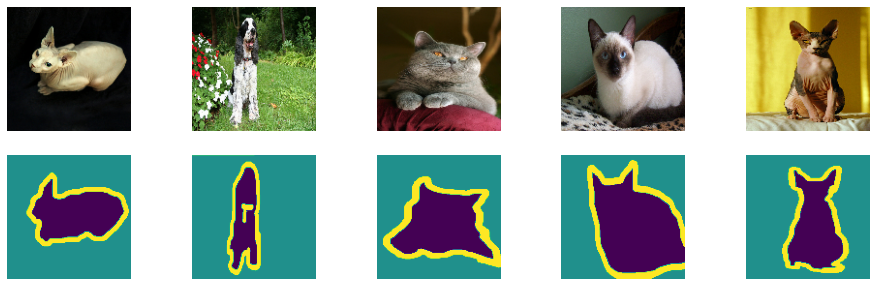

In [14]:
f, ax = plt.subplots(2, 5, figsize=(16,5))
for idx,(img, mask) in enumerate(train.take(5)):
    ax[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[0, idx].axis('off')
    mask = tf.reshape(mask, [128, 128])
    ax[1, idx].imshow(mask.numpy())
    ax[1, idx].axis('off')

## U-Net
ここで使用するモデルは、[U-Net](https://link.springer.com/content/pdf/10.1007%2F978-3-319-24574-4_28.pdf)に変更を加えたものです。  
U-Netは通常、画像をエンコードにダウンサンプリングするエンコーダーと、エンコードを目的のマスクにアップサンプリングするデコーダーで構成されます。デコーダーブロックには、エンコーダーブロックをデコーダーに直接接続するいくつかのスキップ接続があります。  

最初からトレーニングを行うには、多くのトレーニング可能なパラメーターが必要であり、第12章で説明されている生成的敵対的ネットワーク(GAN)を使用する方が適切です。  

このノートブックでは、事前にトレーニングされたMobileNetV2を使用してエンコーディングを作成し、アップサンプリングレイヤーのセットを使用して目的のマスクのサイズに戻します。  
ただし、そうする場合は、必要なサイズのレイヤーを取得し、アップサンプリングスキップレイヤーがトレーニング済みモデルと対応する重みを使用するようにする必要があります。

データセットを最大限利用するために、学習用データセットでは画像を反転させてデータ拡張を行います。
(データ拡張については第6章で説明します)  

出力は3つのチャネルで構成されていることに注意してください。これは、ピクセルごとに3つのラベル(背景、輪郭、内部)があるためです。3つの可能なクラスを持つ複数分類の問題と考えてください。


In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    return img, mask

train_dataset = train.cache().map(augment).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers to form skip connections
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs,
                            name='pretrained_mobilenet')

down_stack.trainable = False

デコーダーは一連のアップサンプルブロックで構成されます。

Conv2DTranspose層でアップサンプリングを行い、バッチ正規化とreluを追加します。

In [18]:
def upsample(filters, size, name):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ], name=name)

up_stack = [
    upsample(512, 3, 'upsample_4x4_to_8x8'),
    upsample(256, 3, 'upsample_8x8_to_16x16'),
    upsample(128, 3, 'upsample_16x16_to_32x32'),
    upsample(64, 3,  'upsample_32x32_to_64x64')
]

In [19]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for idx, (up, skip) in enumerate(zip(up_stack, skips)):
        x = up(x)
        concat = tf.keras.layers.Concatenate(name='expand_{}'.format(idx))
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

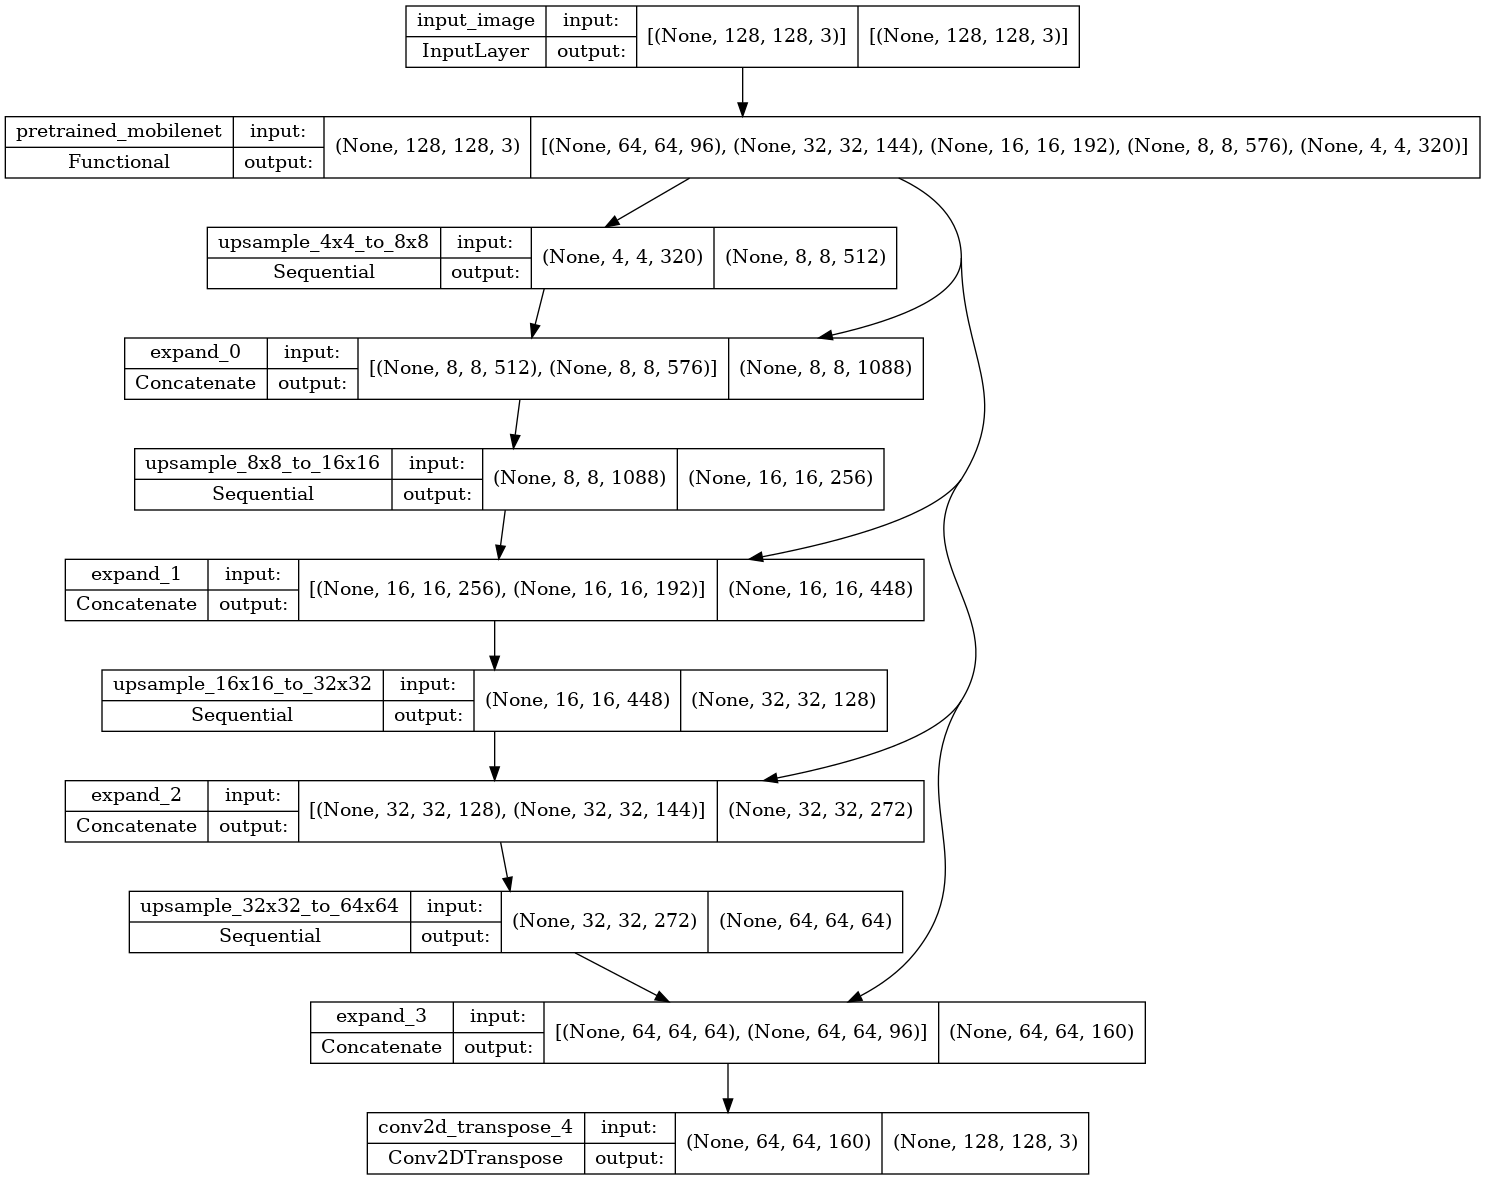

In [20]:
model = unet_model(OUTPUT_CHANNELS)
tf.keras.utils.plot_model(model, show_shapes=True)

## モデルの学習

マルチクラス予測問題として扱います。  
したがって、損失関数には`SparseCategoricalCrossentropy`、評価指標には`accuracy`を利用します。

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# Assign to the pixel the label with the highest probability
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

学習中にモデル出力を確認するヘルパー関数

In [23]:
# display helper functions
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(dataset, num):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

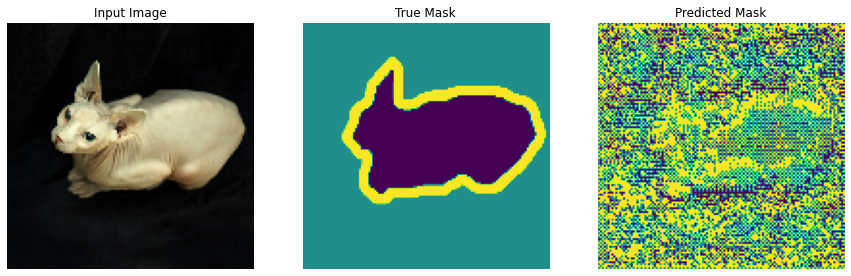

In [24]:
# before the model is trained
show_predictions(train.batch(1), 1)

学習中にモデルがどのように改善されるかを観察するために、エポックが終了したときに予測を表示するコールバック関数を定義し、5エポック毎に出力します。

In [25]:
# from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch%5 == 0:
          # clear_output(wait=True) # if you want replace the images each time, uncomment this
            show_predictions(train.batch(1), 1)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
 6/57 [==>...........................] - ETA: 20s - loss: 1.2391 - accuracy: 0.4273WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_train_batch_end` time: 0.5745s). Check your callbacks.


57/57 [==============================] - ETA: 0s - loss: 0.7889 - accuracy: 0.6662

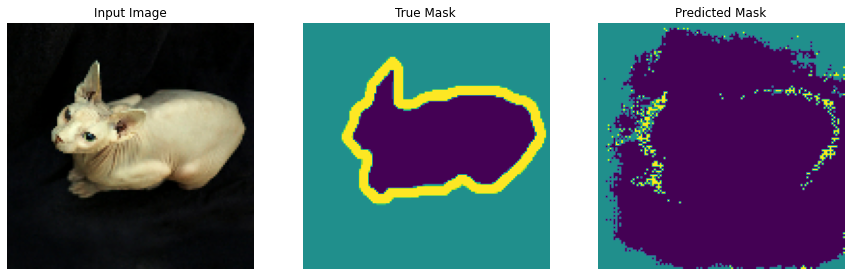


Sample Prediction after epoch 1

57/57 [==============================] - 33s 508ms/step - loss: 0.7889 - accuracy: 0.6662 - val_loss: 2.2390 - val_accuracy: 0.4526
Epoch 2/20
57/57 [==============================] - 25s 444ms/step - loss: 0.6171 - accuracy: 0.7415 - val_loss: 0.7730 - val_accuracy: 0.6839
Epoch 3/20
57/57 [==============================] - 25s 443ms/step - loss: 0.5896 - accuracy: 0.7523 - val_loss: 0.5953 - val_accuracy: 0.7524
Epoch 4/20
57/57 [==============================] - 25s 442ms/step - loss: 0.5751 - accuracy: 0.7590 - val_loss: 0.5827 - val_accuracy: 0.7546
Epoch 5/20
57/57 [==============================] - 25s 442ms/step - loss: 0.5594 - accuracy: 0.7660 - val_loss: 0.5729 - val_accuracy: 0.7585
Epoch 6/20
57/57 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7690

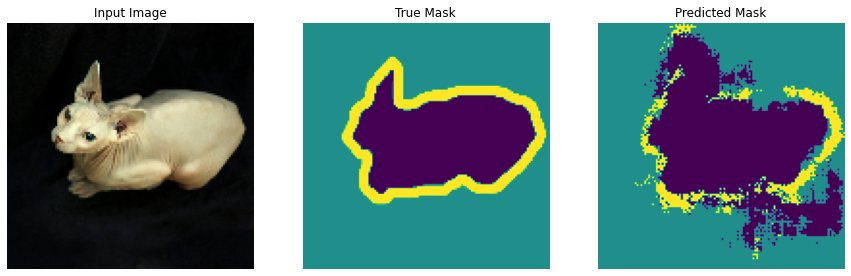


Sample Prediction after epoch 6

57/57 [==============================] - 26s 452ms/step - loss: 0.5530 - accuracy: 0.7690 - val_loss: 0.5851 - val_accuracy: 0.7545
Epoch 7/20


2022-12-10 21:00:30.013846: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 4953, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670706030.013736308","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 4953, Output num: 1","grpc_status":3}


57/57 [==============================] - 25s 442ms/step - loss: 0.5458 - accuracy: 0.7718 - val_loss: 0.5556 - val_accuracy: 0.7683
Epoch 8/20
57/57 [==============================] - 25s 442ms/step - loss: 0.5393 - accuracy: 0.7744 - val_loss: 0.5481 - val_accuracy: 0.7712
Epoch 9/20
57/57 [==============================] - 25s 445ms/step - loss: 0.5348 - accuracy: 0.7764 - val_loss: 0.5803 - val_accuracy: 0.7554
Epoch 10/20
57/57 [==============================] - 25s 446ms/step - loss: 0.5253 - accuracy: 0.7807 - val_loss: 0.5494 - val_accuracy: 0.7710
Epoch 11/20
57/57 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7803

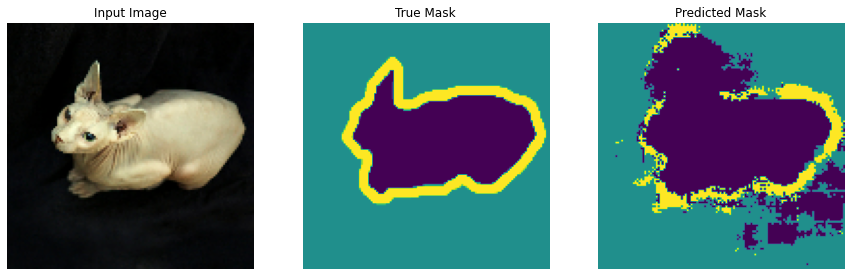


Sample Prediction after epoch 11

57/57 [==============================] - 26s 453ms/step - loss: 0.5254 - accuracy: 0.7803 - val_loss: 0.5441 - val_accuracy: 0.7741
Epoch 12/20


2022-12-10 21:02:36.843815: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 7114, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670706156.843622596","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 7114, Output num: 0","grpc_status":3}


57/57 [==============================] - 25s 445ms/step - loss: 0.5196 - accuracy: 0.7830 - val_loss: 0.5375 - val_accuracy: 0.7749
Epoch 13/20
57/57 [==============================] - 25s 445ms/step - loss: 0.5123 - accuracy: 0.7866 - val_loss: 0.5625 - val_accuracy: 0.7647
Epoch 14/20
57/57 [==============================] - 25s 443ms/step - loss: 0.5111 - accuracy: 0.7861 - val_loss: 0.5452 - val_accuracy: 0.7691
Epoch 15/20
57/57 [==============================] - 25s 443ms/step - loss: 0.5049 - accuracy: 0.7887 - val_loss: 0.5412 - val_accuracy: 0.7773
Epoch 16/20
57/57 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7898

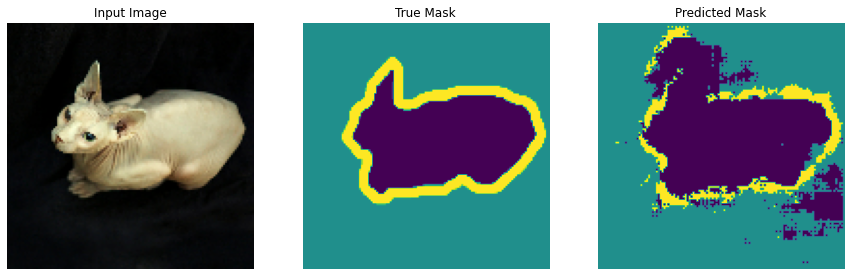


Sample Prediction after epoch 16

57/57 [==============================] - 26s 452ms/step - loss: 0.5028 - accuracy: 0.7898 - val_loss: 0.5336 - val_accuracy: 0.7769
Epoch 17/20


2022-12-10 21:04:43.758843: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 9275, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670706283.758739151","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 9275, Output num: 1","grpc_status":3}


57/57 [==============================] - 25s 444ms/step - loss: 0.4970 - accuracy: 0.7927 - val_loss: 0.5346 - val_accuracy: 0.7760
Epoch 18/20
57/57 [==============================] - 25s 447ms/step - loss: 0.4955 - accuracy: 0.7928 - val_loss: 0.5350 - val_accuracy: 0.7783
Epoch 19/20
57/57 [==============================] - 25s 443ms/step - loss: 0.4934 - accuracy: 0.7939 - val_loss: 0.5401 - val_accuracy: 0.7761
Epoch 20/20
57/57 [==============================] - 25s 443ms/step - loss: 0.4932 - accuracy: 0.7939 - val_loss: 0.5623 - val_accuracy: 0.7665


In [26]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

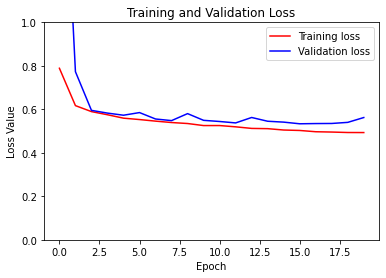

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 推論
では、テスト用データセットからいくつかの画像を推論し、マスクを作成してみましょう。

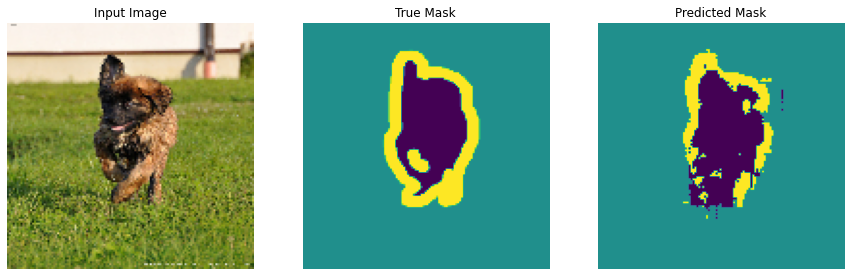

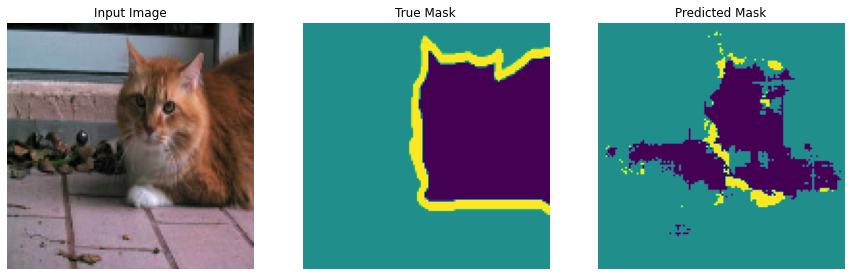

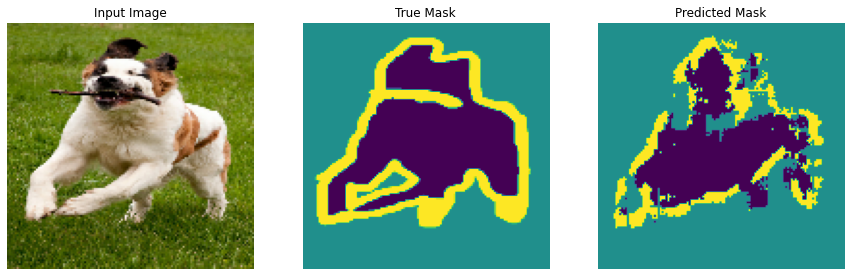

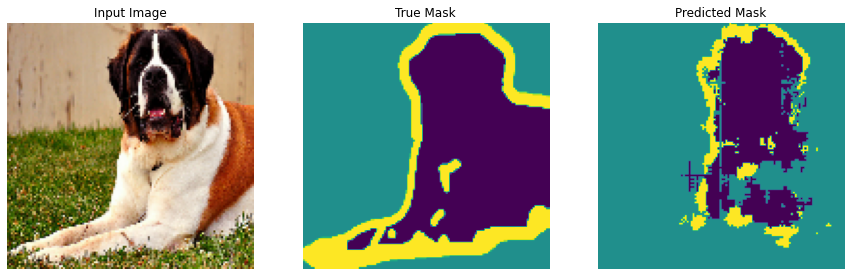

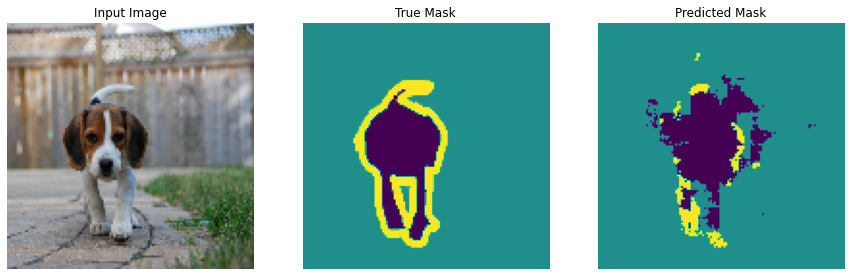

2022-12-10 21:06:27.123470: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 11233, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670706387.123374734","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11233, Output num: 1","grpc_status":3}


In [28]:
show_predictions(test.batch(1), 5)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook is based on https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb which is also licensed under Apache 2